In [69]:
import numpy as np
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import random
from matplotlib.animation import FuncAnimation
import cv2

In [37]:
data_img_dir = Path("data", "train")
data_csv_file = Path("data", "train.csv")
cases_dirs = next(os.walk(data_img_dir))[1]
train_segmentations_df = pd.read_csv(data_csv_file)

def rle_decode(mask_rle, shape):
    """
    Decode a run-length encoded string into a binary mask.
    
    Parameters:
    - mask_rle: Run-length as string formatted (start length)
    - shape: (height, width) of array to return
    
    Returns:
    - Numpy array of shape (height, width)
    """
    if pd.isna(mask_rle):
        return np.zeros(shape[0] * shape[1], dtype=np.uint8)
    else:
        s = list(map(int, mask_rle.split()))
        starts, lengths = [np.asarray(x) for x in (s[0::2], s[1::2])]
        starts -= 1
        ends = starts + lengths
        img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
        return img.reshape(shape)
    
# Normalize array between 0 and 255
def normalize_array(array):
    # Normalize the image to the range 0-255 with precision
    image_min = array.min()
    image_max = array.max()

    # Handle the case where all values are the same to avoid division by zero
    if image_max > image_min:
        image_normalized = (array - image_min) * (255.0 / (image_max - image_min))
    else:
        image_normalized = np.zeros_like(array)

    return image_normalized

def create_overlay(image, mask, rle, colour, alpha):
    # Create an RGBA overlay with transparency
    overlay = Image.new('RGBA', image.size, colour + (0,))  # green color, fully transparent
    draw = ImageDraw.Draw(overlay)

    if not pd.isna(rle):
        # Get the coordinates of the mask
        mask_coords = np.where(mask == 1)
        for y, x in zip(mask_coords[0], mask_coords[1]):
            draw.point((x, y), fill=colour+(alpha,))  # green color, semi-transparent
    
    combined = Image.alpha_composite(image, overlay)
    return combined


In [92]:
rand_case = "case123"#random.choice(cases_dirs)
days_dirs = next(os.walk(data_img_dir / rand_case))
rand_day = "case123_day0"#random.choice(days_dirs[1])

scans = next(os.walk(Path(days_dirs[0]) / rand_day / "scans"))
frames = []
for scan in scans[2]:
    img_info = scan.split("_")
    img_path = Path(scans[0]) / scan
    segmentation_id = rand_day + "_" + img_info[0] + "_" + img_info[1]
    segmentation = train_segmentations_df.set_index("id").loc[segmentation_id]
    img_shape = (int(img_info[3]), int(img_info[2]))

    rle_small_bowel = segmentation[segmentation["class"] == "small_bowel"]["segmentation"].values[0]
    rle_large_bowel = segmentation[segmentation["class"] == "large_bowel"]["segmentation"].values[0]
    rle_stomach = segmentation[segmentation["class"] == "stomach"]["segmentation"].values[0]
    small_bowel_mask = rle_decode(rle_small_bowel, img_shape)
    large_bowel_mask = rle_decode(rle_large_bowel, img_shape)
    stomach_mask = rle_decode(rle_stomach, img_shape)

    normalized_image = normalize_array(np.asarray(Image.open(img_path)))
    img = Image.fromarray(normalized_image)

    # Normalize the 16-bit grayscale image to 8-bit
    img_8bit = Image.fromarray(normalized_image.astype(np.uint8))  # Convert to 8-bit)

    # Convert the grayscale image to RGBA by replicating grayscale values across R, G, and B channels
    img_rgba = Image.merge("RGBA", (img_8bit, img_8bit, img_8bit, Image.new('L', img.size, 255)))
    x = img_rgba.size
    small_bowel_overlay = create_overlay(image=img_rgba, mask=small_bowel_mask, rle=rle_small_bowel, colour=(255, 0, 0), alpha=80)
    large_bowel_overlay = create_overlay(image=small_bowel_overlay, mask=large_bowel_mask, rle=rle_large_bowel, colour=(0, 255, 0), alpha=80)
    stomach_overlay = create_overlay(image=large_bowel_overlay, mask=stomach_mask, rle=rle_stomach, colour=(0, 0, 255), alpha=80)

    all_overlayed = stomach_overlay
    frames.append(all_overlayed)


# Assuming all frames are of the same size
frame_height, frame_width = np.array(frames[0]).shape[:2]

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 files
output_path = 'animation1.mp4'
out = cv2.VideoWriter(output_path, fourcc, 30.0, (frame_width, frame_height))

# Save each frame to the video file
for frame in frames:
    # Convert PIL Image to numpy array
    frame_np = np.array(frame)

    # Convert RGBA to RGB (OpenCV requires RGB format)
    frame_rgb = cv2.cvtColor(frame_np, cv2.COLOR_RGBA2RGB)
    
    # Write the frame to the video
    out.write(frame_rgb)

# Release the VideoWriter object
out.release()

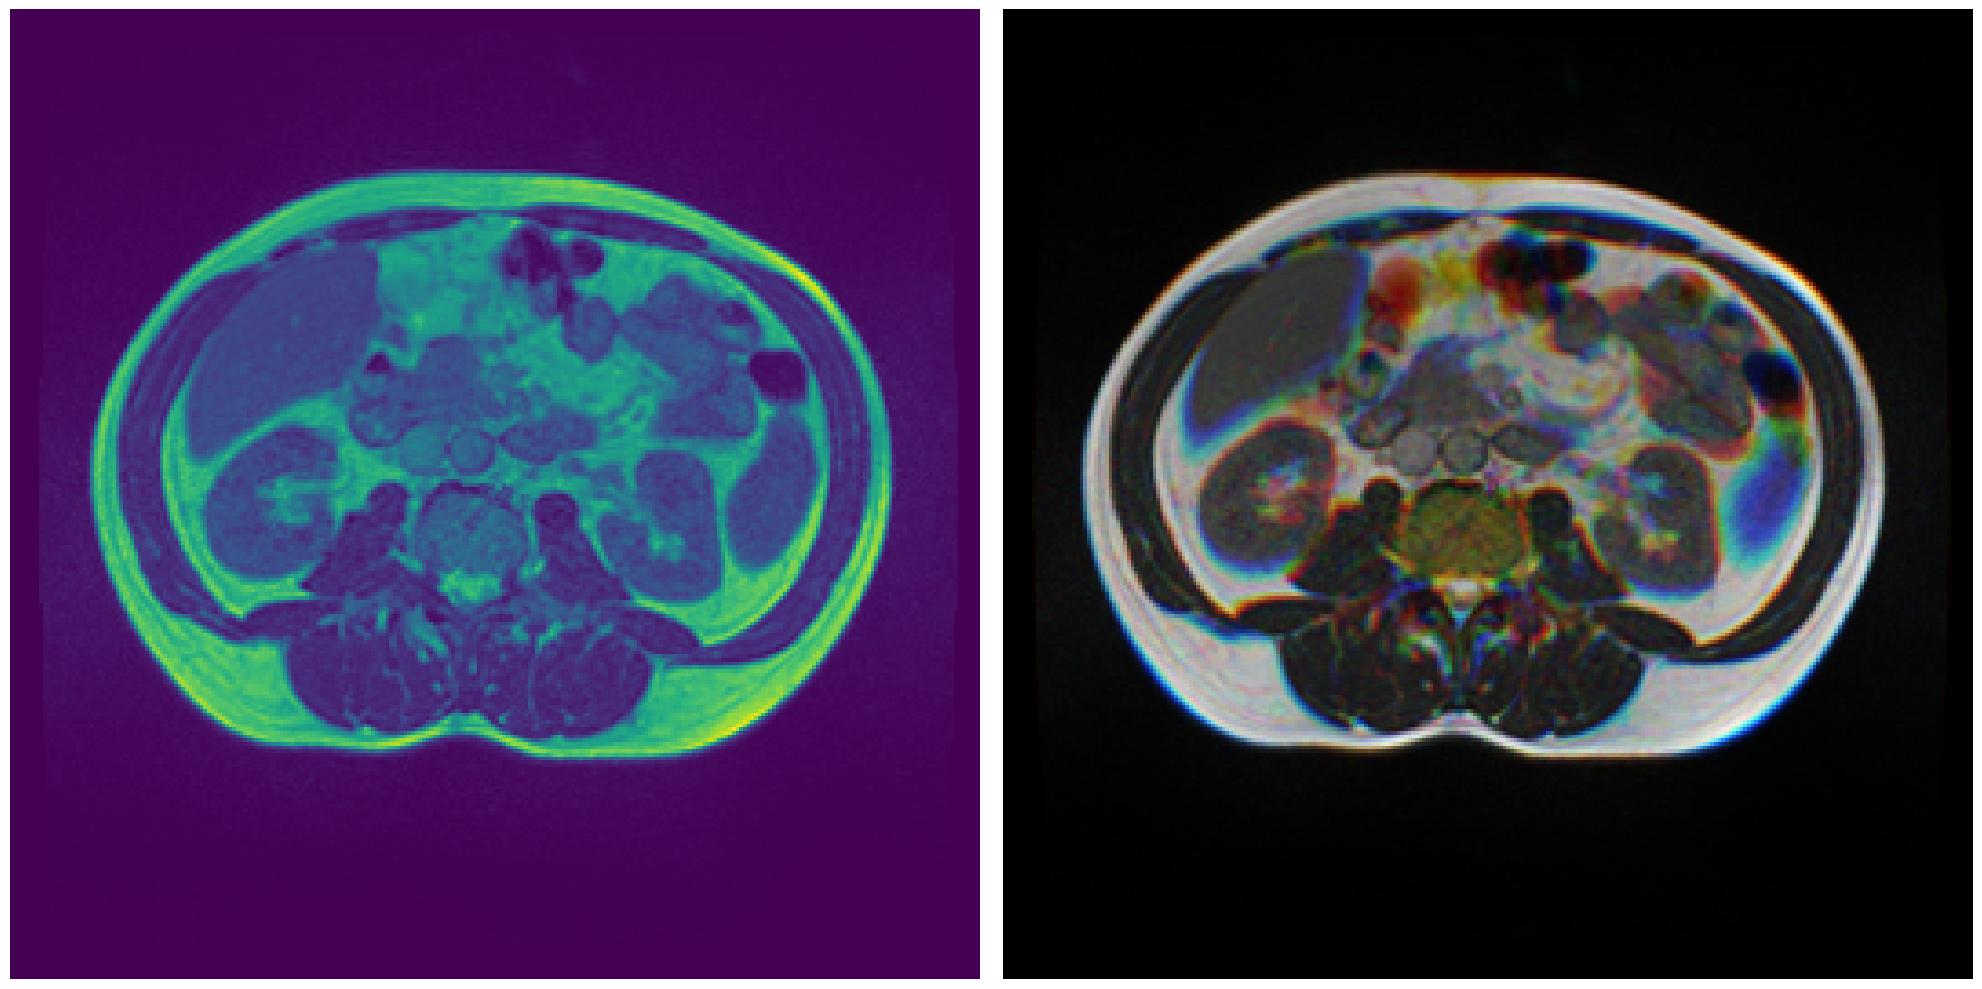

In [91]:
from matplotlib.patches import Rectangle

im1_path = 'data/train/case20/case20_day22/scans/slice_0092_266_266_1.50_1.50.png'
im2_path = 'data/train/case20/case20_day22/scans/slice_0094_266_266_1.50_1.50.png'
im3_path = 'data/train/case20/case20_day22/scans/slice_0096_266_266_1.50_1.50.png'

IMG_SIZE = [266,266]

def load_img(path, size=IMG_SIZE):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    shape0 = np.array(img.shape[:2])
    resize = np.array(size)
    if np.any(shape0!=resize):
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0//2, pad0//2 + pad0%2]
        padx = [pad1//2, pad1//2 + pad1%2]
        img = np.pad(img, [pady, padx])
        img = img.reshape(tuple(*resize))

    return img


def show_img(img, mask=None):
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = [ "Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')
    
def load_imgs(img_paths, size=IMG_SIZE):
    imgs = np.zeros((*size, len(img_paths)), dtype=np.uint16)
    for i, img_path in enumerate(img_paths):
        img = load_img(img_path, size=size)
        imgs[..., i]+=img
    return imgs

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
img = load_img(im1_path).astype('float32')
img/=img.max()
plt.imshow(img)
plt.axis('off')


plt.subplot(1, 2, 2)
imgs = load_imgs([im1_path,im2_path,im3_path]).astype('float32')
imgs/=imgs.max(axis=(0,1))
plt.imshow(imgs)
plt.axis('off')

plt.tight_layout()
plt.show()